# LLM Random Number Picker

Inspired by this [Information is Beautiful viz on what random number ChatGPT guesses](https://twitter.com/infobeautiful/status/1778059112250589561), I tried the same with 3 LLMs.

In [1]:
import os
import json
import httpx


# If we have prior cached data, load it
data = {}
if os.path.exists("llm-random-numbers.json"):
    with open("llm-random-numbers.json", "r") as f:
        data = json.load(f)


def claude_haiku(temperature):
    r = httpx.post(
        "https://api.anthropic.com/v1/messages",
        headers={
            "x-api-key": os.environ["ANTHROPIC_API_KEY"],
            "anthropic-version": "2023-06-01",
            "content-type": "application/json",
        },
        json={
            "model": "claude-3-haiku-20240307",
            "max_tokens": 2,
            "temperature": temperature,
            "messages": [
                {
                    "role": "user",
                    "content": "Pick a random number from 0 - 100. Write ONLY the number NOTHING ELSE",
                }
            ],
        },
    )
    r.raise_for_status()
    return r.json()["content"][0]["text"]


def openai_gpt_35(temperature):
    r = httpx.post(
        "https://api.openai.com/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
            "content-type": "application/json",
        },
        json={
            "model": "gpt-3.5-turbo",
            "max_tokens": 2,
            "temperature": temperature,
            "messages": [
                {
                    "role": "user",
                    "content": "Pick a random number from 0 - 100. Write ONLY the number NOTHING ELSE",
                }
            ],
        },
    )
    r.raise_for_status()
    return r.json()["choices"][0]["message"]["content"]


def google_gemini(temperature):
    r = httpx.post(
        "https://europe-west2-aiplatform.googleapis.com/v1/projects/{GOOGLE_PROJECT}/locations/europe-west2/publishers/google/models/gemini-1.0-pro-001:generateContent".format(**os.environ),
        headers={
            "Authorization": f"Bearer {os.environ['GOOGLE_API_KEY']}",
            "content-type": "application/json",
        },
        json={
            "contents": [
                {
                    "role": "user",
                    "parts": [
                        {
                            "text": "Pick a random number from 0 - 100. Write ONLY the number NOTHING ELSE",
                        }
                    ]
                }
            ],
            "generationConfig": {
                "maxOutputTokens": 2,
                "temperature": temperature,
            },
        },
    )
    r.raise_for_status()
    return r.json()["candidates"][0]["content"]["parts"][0]["text"]


# Get 200 random numbers
for attempt in range(0, 200):
    # At each temperature from 1.0 to 0.0
    for t in range(100, -1, -10):
        temperature = t / 100
        # For each provider
        for provider, method in [("O", openai_gpt_35), ("C", claude_haiku), ("G", google_gemini)]:
            # Store data as a key-value pair. The key is "Provider,Temperature,Attempt"
            key = f"{provider},{temperature:.2f},{attempt}"
            if key in data:
                continue
            print(key)
            data[key] = method(temperature)
            with open("llm-random-numbers.json", "w") as f:
                json.dump(data, f, sort_keys=True)


In [2]:
# Convert data into a Pandas DataFrame with columns "t" (for temperature), "#" for attempt, and "n" for the random number
import pandas as pd
df = pd.DataFrame([{"m": k.split(",")[0], "t": float(k.split(",")[1]), "#": int(k.split(",")[2]), "n": int(v)} for k, v in data.items()])
df

,m,t,#,n
0,C,0.0,0,42
1,C,0.0,1,42
2,C,0.0,10,42
3,C,0.0,100,42
4,C,0.0,101,42
...,...,...,...,...
6595,O,1.0,95,56
6596,O,1.0,96,74
6597,O,1.0,97,79
6598,O,1.0,98,47


## OpenAI GPT 3.5 Turbo prefers 47

- Clearly prefers 47!
- No single-digit numbers
- Prefers numbers ending with 7: 37, 47, 57, 67, but not 27, 77, 97.
- 72, 73 are also popular.

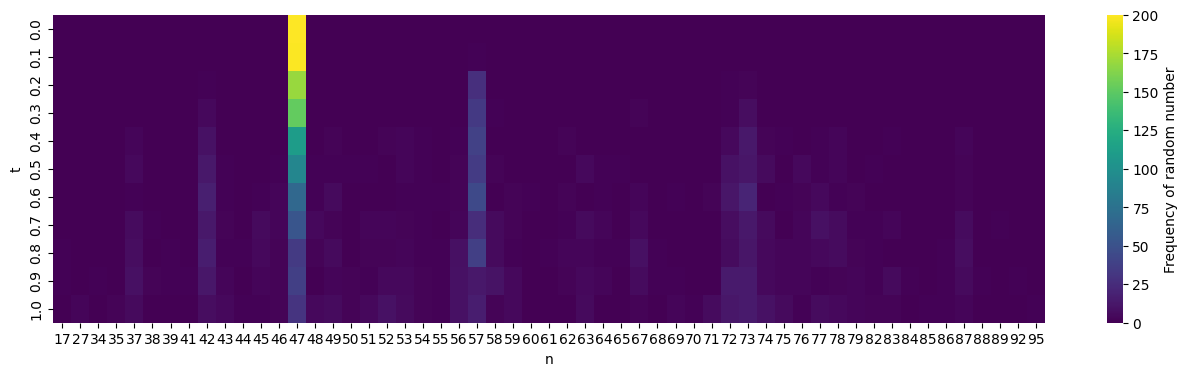

In [3]:
# Draw a heatmap of the random numbers. X-axis is the random number n, Y-axis is the temperature t, and the color is the frequency of that random number at that temperature.
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
pivot = df[df["m"] == "O"].pivot_table(index="t", columns="n", values="#", aggfunc="count").fillna(0)
sns.heatmap(pivot, cmap="viridis", cbar_kws={'label': 'Frequency of random number'})
plt.show()

## Anthropic Claude 3 Haiku loves 42

- Clearly prefers 42!
- Guesses numbers in a much smaller range (23-87) compared to OpenAI.
- No single-digit numbers
- Prefers numbers ending with 7: 37, 47, 57, 67, also 27, 87, but not 77.
- Prefers multiples of 9: 72, 45, 54, 63 are pretty popular.
- 72, 73 are also popular.
- Avoids multiples of 10.

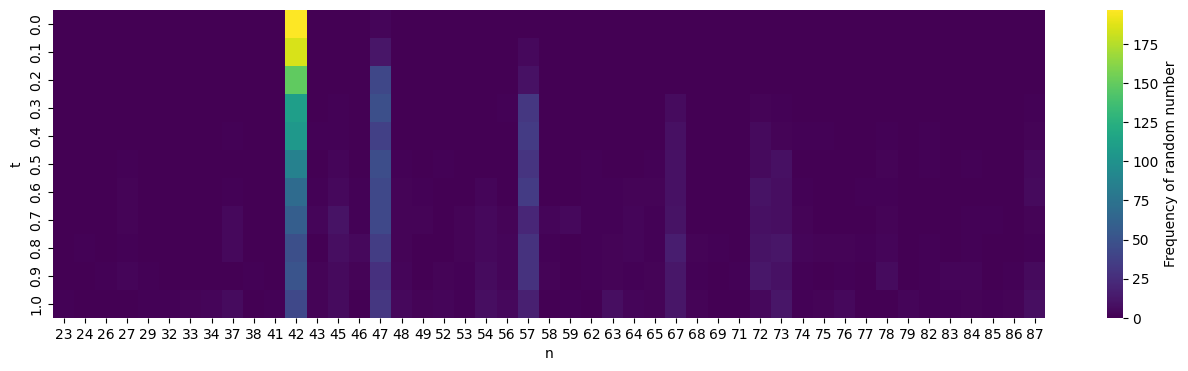

In [4]:
plt.figure(figsize=(16, 4))
pivot = df[df["m"] == "C"].pivot_table(index="t", columns="n", values="#", aggfunc="count").fillna(0)
sns.heatmap(pivot, cmap="viridis", cbar_kws={'label': 'Frequency of random number'})
plt.show()

## Google Gemini 1.0 Pro likes 72

- Clearly prefers 72!
- Guesses numbers in a much smaller range (23-87) compared to OpenAI.
- Few single-digit numbers
- Prefers numbers ending with 7: 27, 37, 47, 57, 67, 77.
- 73 is also popular.
- Avoids multiples of 10, with rare exceptions.

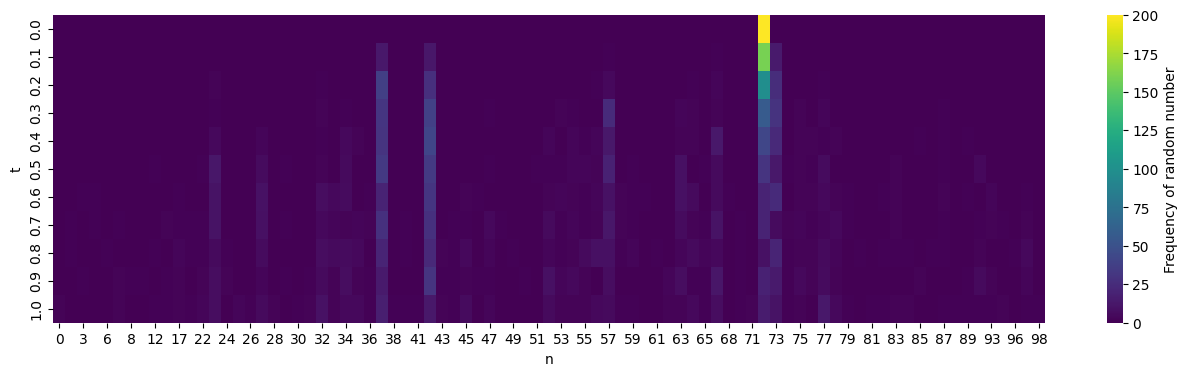

In [5]:
plt.figure(figsize=(16, 4))
pivot = df[df["m"] == "G"].pivot_table(index="t", columns="n", values="#", aggfunc="count").fillna(0)
sns.heatmap(pivot, cmap="viridis", cbar_kws={'label': 'Frequency of random number'})
plt.show()